In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

from tqdm import tqdm
import yaml

from scipy.stats import binned_statistic_2d
# import shap

from flash_ansr import get_path, ExpressionSpace
from flash_ansr.eval.utils import bootstrapped_metric_ci

In [2]:
def nan_false_statistic(X, statistic):
    X_copy = np.array(X)
    # Where X is nan, replace with False
    X_copy[np.isnan(X_copy)] = False
    return statistic(X_copy)

In [3]:
MODELS = [os.path.join('analysis_beams', m) for m in os.listdir(get_path('results', 'evaluation', 'analysis_beams'))]

In [4]:
MODELS_DESCRIPTION = {k: k.replace('v6.0_', '') for k in MODELS}

In [5]:
TEST_SETS = ['train', 'val', 'feynman', 'soose_nc', 'nguyen', 'pool_15']
TEST_SET_TITLES = {
    'train': 'Train',
    'val': 'Val',
    'feynman': 'Feynman',
    'soose_nc': 'S.-NC',
    'nguyen': 'Nguyen',
    'pool_15': 'Pool 15',
}

In [6]:
configs = {}

for model in MODELS:
    with open(get_path(f'configs/{model}/evaluation.yaml'), 'r') as f:
        configs[model] = yaml.safe_load(f)

In [7]:
test_sets = {model: [path.replace('.pickle', '') for path in os.listdir(get_path(f'results/evaluation/{model}'))] for model in MODELS}

for model, model_test_sets in test_sets.items():
    # Reorder the test sets as follows: train, val, feynman, soose_nc, nguyen
    for i, s in enumerate(TEST_SETS):
        if s in model_test_sets:
            model_test_sets.remove(s)
            model_test_sets.insert(i, s)

In [8]:
results = {}

for model, model_test_sets in test_sets.items():
    results[model] = {test_set: {'path': get_path(f'results/evaluation/{model}/{test_set}.pickle')} for test_set in model_test_sets}

In [9]:
remove_invalid = []

for model, model_results in results.items():
    for test_set, test_set_results in tqdm(model_results.items(), desc=f'Loading {model} results'):
        with open(test_set_results['path'], 'rb') as f:
            test_set_results['data'] = pickle.load(f)

            columns_to_rename = set()
            for k, v in test_set_results['data'].items():
                try:
                    test_set_results['data'][k] = np.array(v)
                except ValueError:
                    pass

                if '_free_' in k:
                    columns_to_rename.add(k)

            for k in columns_to_rename:
                test_set_results['data'][k.replace('_free_', '_')] = test_set_results['data'][k]
                del test_set_results['data'][k]

            keys_to_remove = [k for k in test_set_results['data'].keys() if 'residuals' in k]
            keys_to_remove.extend(['x', 'y'])

            for k in keys_to_remove:
                del test_set_results['data'][k]

Loading analysis_beams/v6.0_2-beams results: 100%|██████████| 4/4 [00:01<00:00,  3.79it/s]


In [10]:
for model, model_results in results.items():
    beam_width = configs[model].get('beam_width', 1)
    n_restarts = configs[model].get('n_restarts', 1)
    # Pad the beams to their maximum length
    for test_set, test_set_results in tqdm(model_results.items()):
        data = test_set_results['data']

        if model == 'pysr':
            results[model][test_set]['data']['wall_time'] = data['fit_time']
            results[model][test_set]['data']['sys_time'] = data['fit_time'] * 32  # 32 cores
        
        elif model == 'nesymres-100M':
            results[model][test_set]['data']['wall_time'] = data['fit_time']
            results[model][test_set]['data']['sys_time'] = data['fit_time']

        else:
            results[model][test_set]['data']['wall_time'] = data['beam_search_time'] + sum(data[f'refiner_time_beam_{j + 1}'] for j in range(beam_width))
            results[model][test_set]['data']['sys_time'] = data['beam_search_time'] + sum(data[f'refiner_time_beam_{j + 1}'] for j in range(beam_width))

100%|██████████| 4/4 [00:00<00:00, 11634.69it/s]


In [11]:
for model, model_results in results.items():
    beam_width = configs[model].get('beam_width', 1)
    # Pad the beams to their maximum length
    for test_set, test_set_results in tqdm(model_results.items()):
        data = test_set_results['data']

        results[model][test_set]['data']['length_target'] = np.array([len(data['input_ids'][i]) for i in range(len(data['input_ids']))])
        
        for j in range(beam_width):
            results[model][test_set]['data'][f'length_beam_{j + 1}'] = np.array([len(data[f'free_beam_{j + 1}'][i]) for i in range(len(data[f'free_beam_{j + 1}']))])

            if f'residuals_beam_{j + 1}' not in data:
                continue
            results[model][test_set]['data'][f'L_inf_beam_{j + 1}'] = np.array([(np.nanmax(np.abs(data[f'residuals_beam_{j + 1}'][i])) if data[f'residuals_beam_{j + 1}'][i] is not None else np.nan) for i in range(len(data[f'residuals_beam_{j + 1}']))])
        
        if '_beam_1' not in data:
            continue

        max_length = max(max([len(beam) for beam in data[f'_beam_{j + 1}']]) for j in range(beam_width))

        for j in range(beam_width):
            padded_beam = [beam + [0] * (max_length - len(beam)) for beam in data[f'_beam_{j + 1}']]
            data[f'_beam_{j + 1}'] = np.array(padded_beam)


100%|██████████| 4/4 [00:00<00:00, 1516.38it/s]


In [12]:
for model, model_results in results.items():
    beam_width = configs[model].get('beam_width', 1)
    for test_set, test_set_results in tqdm(model_results.items()):
        valid = True
        data = test_set_results['data']

        beam_columns = [k.replace('_beam_1', '') for k in data.keys() if k.endswith(f'beam_1') and not 'residuals' in k and not 'free' in k]

        # Create new columns with metrics of the best beam (by mse_{generation_type}_beam_{i}) and store it as {metric}_{generation_type}_best_beam
        # Create new columns
        for column in beam_columns:
            if isinstance(data[column + '_beam_1'][0], np.ndarray):
                data[column + '_best_beam'] = np.nan * np.ones_like(data[column + '_beam_1'])
            else:
                data[column + '_best_beam'] = np.nan * np.ones(len(data[column + '_beam_1']))

        data['best_beam'] = np.nan * np.ones(len(data['mse_beam_1']))

        # For each instance, find the best beam by mse
        for i in range(len(data['mse_beam_1'])):
            mse_list = np.array([data[f'mse_beam_{j}'][i] for j in range(1, beam_width+1) if f'mse_beam_{j}' in data.keys()])
            if np.all(np.isnan(mse_list)):
                continue
            best_beam = np.nanargmin([data[f'mse_beam_{j}'][i] for j in range(1, beam_width+1) if f'mse_beam_{j}' in data.keys()]) + 1
            data['best_beam'][i] = best_beam
            for column in beam_columns:
                data[column + '_best_beam'][i] = data[column + f'_beam_{best_beam}'][i]

100%|██████████| 4/4 [00:00<00:00, 50.58it/s]


In [13]:
# Design features
for model, model_results in results.items():
    for test_set, test_set_results in model_results.items():
        test_set_results['data']['is_finite'] = np.array([np.isfinite(r2) for r2 in test_set_results['data']['r2_best_beam']])

        test_set_results['data']['FVU-eps_accuracy'] = np.array([(1 - r2) <= np.finfo(np.float32).eps for r2 in test_set_results['data']['r2_best_beam']])

        test_set_results['data']['fvu'] = np.array([1 - r2 for r2 in test_set_results['data']['r2_best_beam']])
        test_set_results['data']['log_fvu'] = np.array([np.log10(1 - r2 + np.finfo(np.float32).eps) for r2 in test_set_results['data']['r2_best_beam']])

        test_set_results['data']['fvu_not_epsilon'] = np.copy(test_set_results['data']['fvu'])
        test_set_results['data']['fvu_not_epsilon'][test_set_results['data']['FVU-eps_accuracy']] = np.nan

        test_set_results['data']['log_fvu_not_epsilon'] = np.array([np.log10(fvu) for fvu in test_set_results['data']['fvu_not_epsilon']])

        if 'perplexity' in test_set_results['data']:
            test_set_results['data']['log_ppl'] = [np.log10(ppl) for ppl in test_set_results['data']['perplexity']]
        else:
            test_set_results['data']['log_ppl'] = [np.nan] * len(test_set_results['data']['r2_best_beam'])

In [14]:
# Find the intersection of the columns of all the dataframes
compare_columns = set.union(*[set(test_set_results['data'].keys()) for model_results in results.values() for test_set_results in model_results.values()])
compare_columns = compare_columns - {'x', 'y', 'constants', 'input_ids', 'labels', 'residuals_beam_1', 'n_support', 'free_best_beam'}
compare_columns = compare_columns - {c for c in compare_columns if any(c.endswith(f'_{i}') or 'free' in c for i in range(1, 1024))}
# compare_columns = compare_columns.union({'perplexity', 'precision_best_beam', 'recall_best_beam', 'meteor_best_beam', 'edit_distance'})
compare_columns

{'FVU-eps_accuracy',
 'NSRTS_accuracy_close_best_beam',
 'NSRTS_accuracy_r2_best_beam',
 'accuracy_best_beam',
 'beam_search_time',
 'best_beam',
 'bleu_best_beam',
 'edit_distance_best_beam',
 'f1_score_best_beam',
 'fvu',
 'fvu_not_epsilon',
 'is_finite',
 'length_best_beam',
 'length_target',
 'log_fvu',
 'log_fvu_not_epsilon',
 'log_ppl',
 'meteor_best_beam',
 'mse_best_beam',
 'perplexity',
 'precision_best_beam',
 'r2_best_beam',
 'recall_best_beam',
 'reciprocal_rank',
 'refiner_time_best_beam',
 'rouge1_fmeasure_best_beam',
 'rouge1_precision_best_beam',
 'rouge1_recall_best_beam',
 'rouge2_fmeasure_best_beam',
 'rouge2_precision_best_beam',
 'rouge2_recall_best_beam',
 'rougeL_fmeasure_best_beam',
 'rougeL_precision_best_beam',
 'rougeL_recall_best_beam',
 'structural_accuracy_best_beam',
 'sys_time',
 'tree_edit_distance_best_beam',
 'wall_time'}

In [15]:
array_dfs = {
    model: {
        test_set:
        pd.DataFrame({k: v for k, v in test_set_results['data'].items() if k in compare_columns}).astype(float)
            for test_set, test_set_results in model_results.items()}
            for model, model_results in results.items()}

In [16]:
compare_columns_defaults = {
    'FVU-eps_accuracy': 0,
    'perplexity': np.inf,
    'log_ppl': np.inf,
    'precision_best_beam': 0,
    'recall_best_beam': 0,
    'L_inf_best_beam': np.inf,
    'NSRTS_accuracy_close_best_beam': 0,
    'NSRTS_accuracy_r2_best_beam': 0,
    'accuracy_best_beam': 0,
    'bleu_best_beam': 0,
    'edit_distance_best_beam': np.inf,
    'f1_score_best_beam': 0,
    'fvu': np.inf,
    'log_fvu': np.inf,
    'fvu_not_epsilon': np.inf,
    'log_fvu_not_epsilon': np.inf,
    'log_ppl': np.inf,
    'meteor_best_beam': 0,
    'mse_best_beam': np.inf,
    'perplexity': np.inf,
    'precision_best_beam': 0,
    'r2_best_beam': -np.inf,
    'recall_best_beam': 0,
    'reciprocal_rank': 0,
    'rouge1_fmeasure_best_beam': 0,
    'rouge1_precision_best_beam': 0,
    'rouge1_recall_best_beam': 0,
    'rouge2_fmeasure_best_beam': 0,
    'rouge2_precision_best_beam': 0,
    'rouge2_recall_best_beam': 0,
    'rougeL_fmeasure_best_beam': 0,
    'rougeL_precision_best_beam': 0,
    'rougeL_recall_best_beam': 0,
    'structural_accuracy_best_beam': 0,
    'tree_edit_distance_best_beam': np.inf,
    'wall_time': np.inf,
    'sys_time': np.inf,
    'is_finite': 0,
}

In [17]:
from functools import partial

In [18]:
def naninfmean(x):
    return np.nanmean(np.array(x)[np.isfinite(x)])

# Per Dataset

In [19]:
summaries = {model: {test_set: {column: {} for column in compare_columns} for test_set, df in model_dfs.items()} for model, model_dfs in array_dfs.items()}
metrics = None

N_BOOTSTRAPS = 1_000

for model, model_dfs in array_dfs.items():
    for test_set, df in model_dfs.items():
        for column in tqdm(compare_columns, desc=f'{model} {test_set}'):
            sub_metrics = ['mean', 'median', '2.5p', '97.5p']
            sub_metrics_functions = [naninfmean, np.nanmedian, partial(np.nanpercentile, q=2.5), partial(np.nanpercentile, q=97.5)]
            if column in df.columns:
                data = df[column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
                summaries[model][test_set][column] = {m: bootstrapped_metric_ci(data, f, n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}
            else:
                summaries[model][test_set][column] = {k: (np.nan, ) * 3 for k in sub_metrics}

            if metrics is None:
                metrics = summaries[model][test_set][column].keys()

analysis_beams/v6.0_128-beams feynman:  11%|█         | 4/38 [00:00<00:03,  9.31it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
analysis_beams/v6.0_512-beams nguyen:  50%|█████     | 19/38 [00:02<00:02,  8.99it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4623: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
analysis_beams/v6.0_1-beams feynman:  24%|██▎       | 9/38 [00:00<00:03,  9.28it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4622: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
analysis_beams/v6.0_2-beams pool_15: 100%|██████████| 38/38 [00:04<00:00,  9.06it/s]


In [20]:
# Show a summary table for each metric
# In each table, the rows are the models and the columns are the test sets
# For columns with 'accuracy' in the name, show the mean. For other columns show the median.

summary_tables = {
    column: {
        metric: {
            percentile:
                pd.DataFrame({
                model: {
                    test_set: summaries[model][test_set][column][metric][k]
                    for test_set in summaries[model].keys()}
                    for model in summaries.keys()}).T.round(3)
                    for k, percentile in enumerate(['median', 'lower', 'upper'])}
                    for metric in metrics}
                    for column in compare_columns}

#### Validity

In [21]:
m = 'is_finite'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams/v6.0_128-beams,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_beams/v6.0_16-beams,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","0.999 (0.997, 1.0)","0.999 (0.997, 1.0)"
analysis_beams/v6.0_32-beams,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_beams/v6.0_64-beams,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_beams/v6.0_8-beams,"1.0 (1.0, 1.0)","0.999 (0.997, 1.0)","0.999 (0.997, 1.0)","0.998 (0.995, 1.0)"
analysis_beams/v6.0_512-beams,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_beams/v6.0_4-beams,"0.999 (0.997, 1.0)","1.0 (1.0, 1.0)","0.998 (0.995, 1.0)","0.992 (0.986, 0.997)"
analysis_beams/v6.0_1-beams,"0.972 (0.961, 0.982)","0.981 (0.972, 0.989)","0.988 (0.98, 0.994)","0.971 (0.96, 0.98)"
analysis_beams/v6.0_256-beams,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_beams/v6.0_2-beams,"0.992 (0.986, 0.997)","0.995 (0.991, 0.999)","0.993 (0.987, 0.998)","0.988 (0.981, 0.995)"


#### Recovery Rate

In [22]:
m = 'NSRTS_accuracy_close_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams/v6.0_128-beams,"0.943 (0.929, 0.957)","0.882 (0.862, 0.901)","0.953 (0.94, 0.966)","0.694 (0.666, 0.723)"
analysis_beams/v6.0_16-beams,"0.865 (0.843, 0.886)","0.793 (0.768, 0.818)","0.81 (0.787, 0.834)","0.599 (0.567, 0.631)"
analysis_beams/v6.0_32-beams,"0.884 (0.864, 0.903)","0.829 (0.806, 0.852)","0.873 (0.852, 0.894)","0.642 (0.612, 0.672)"
analysis_beams/v6.0_64-beams,"0.915 (0.897, 0.931)","0.857 (0.834, 0.878)","0.917 (0.899, 0.933)","0.688 (0.66, 0.718)"
analysis_beams/v6.0_8-beams,"0.82 (0.797, 0.843)","0.753 (0.724, 0.781)","0.797 (0.773, 0.822)","0.578 (0.548, 0.606)"
analysis_beams/v6.0_512-beams,"0.968 (0.957, 0.978)","0.904 (0.886, 0.922)","0.991 (0.985, 0.996)","0.723 (0.695, 0.749)"
analysis_beams/v6.0_4-beams,"0.764 (0.735, 0.79)","0.686 (0.657, 0.715)","0.732 (0.704, 0.758)","0.523 (0.49, 0.553)"
analysis_beams/v6.0_1-beams,"0.642 (0.612, 0.672)","0.493 (0.464, 0.527)","0.563 (0.531, 0.594)","0.416 (0.385, 0.446)"
analysis_beams/v6.0_256-beams,"0.947 (0.932, 0.96)","0.883 (0.864, 0.901)","0.987 (0.979, 0.993)","0.709 (0.682, 0.737)"
analysis_beams/v6.0_2-beams,"0.691 (0.663, 0.718)","0.571 (0.542, 0.601)","0.622 (0.592, 0.653)","0.46 (0.429, 0.49)"


In [23]:
m = 'NSRTS_accuracy_r2_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams/v6.0_128-beams,"0.98 (0.971, 0.988)","0.925 (0.908, 0.942)","0.994 (0.989, 0.998)","0.866 (0.844, 0.886)"
analysis_beams/v6.0_16-beams,"0.922 (0.905, 0.938)","0.849 (0.826, 0.87)","0.976 (0.966, 0.985)","0.798 (0.776, 0.822)"
analysis_beams/v6.0_32-beams,"0.941 (0.924, 0.955)","0.874 (0.852, 0.895)","0.982 (0.974, 0.99)","0.821 (0.798, 0.844)"
analysis_beams/v6.0_64-beams,"0.97 (0.959, 0.98)","0.9 (0.883, 0.918)","0.992 (0.986, 0.997)","0.855 (0.833, 0.877)"
analysis_beams/v6.0_8-beams,"0.904 (0.887, 0.921)","0.83 (0.807, 0.853)","0.953 (0.94, 0.964)","0.77 (0.745, 0.796)"
analysis_beams/v6.0_512-beams,"0.988 (0.981, 0.995)","0.936 (0.921, 0.951)","0.999 (0.997, 1.0)","0.892 (0.872, 0.912)"
analysis_beams/v6.0_4-beams,"0.85 (0.827, 0.871)","0.766 (0.741, 0.793)","0.93 (0.914, 0.945)","0.704 (0.677, 0.732)"
analysis_beams/v6.0_1-beams,"0.741 (0.714, 0.769)","0.596 (0.564, 0.626)","0.778 (0.752, 0.804)","0.549 (0.518, 0.579)"
analysis_beams/v6.0_256-beams,"0.976 (0.966, 0.984)","0.917 (0.9, 0.933)","0.999 (0.997, 1.0)","0.881 (0.861, 0.9)"
analysis_beams/v6.0_2-beams,"0.795 (0.769, 0.82)","0.672 (0.643, 0.7)","0.818 (0.794, 0.842)","0.623 (0.592, 0.651)"


In [24]:
m = 'FVU-eps_accuracy'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams/v6.0_128-beams,"0.837 (0.814, 0.858)","0.799 (0.774, 0.824)","0.91 (0.891, 0.928)","0.427 (0.397, 0.458)"
analysis_beams/v6.0_16-beams,"0.739 (0.711, 0.766)","0.687 (0.656, 0.715)","0.659 (0.63, 0.691)","0.32 (0.289, 0.351)"
analysis_beams/v6.0_32-beams,"0.767 (0.74, 0.792)","0.738 (0.712, 0.765)","0.74 (0.712, 0.767)","0.373 (0.347, 0.406)"
analysis_beams/v6.0_64-beams,"0.805 (0.78, 0.831)","0.78 (0.754, 0.803)","0.841 (0.817, 0.862)","0.421 (0.391, 0.45)"
analysis_beams/v6.0_8-beams,"0.684 (0.654, 0.712)","0.619 (0.592, 0.65)","0.587 (0.557, 0.618)","0.302 (0.276, 0.332)"
analysis_beams/v6.0_512-beams,"0.884 (0.862, 0.904)","0.87 (0.849, 0.89)","0.961 (0.949, 0.971)","0.436 (0.405, 0.467)"
analysis_beams/v6.0_4-beams,"0.64 (0.611, 0.668)","0.552 (0.52, 0.582)","0.54 (0.51, 0.57)","0.3 (0.272, 0.326)"
analysis_beams/v6.0_1-beams,"0.545 (0.515, 0.575)","0.393 (0.365, 0.422)","0.422 (0.391, 0.453)","0.203 (0.179, 0.227)"
analysis_beams/v6.0_256-beams,"0.847 (0.824, 0.869)","0.826 (0.801, 0.849)","0.95 (0.936, 0.962)","0.433 (0.402, 0.463)"
analysis_beams/v6.0_2-beams,"0.585 (0.556, 0.617)","0.462 (0.432, 0.493)","0.448 (0.417, 0.479)","0.226 (0.2, 0.252)"


#### Numeric Error

In [25]:
m = 'fvu'
sm = '97.5p'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams/v6.0_128-beams,"0.01 (0.005, 0.085)","0.997 (0.989, 0.999)","0.002 (0.0, 0.005)","0.962 (0.881, 0.99)"
analysis_beams/v6.0_16-beams,"0.974 (0.879, 0.991)","1.439 (1.108, 1.613)","0.031 (0.008, 0.114)","1.032 (1.0, 1.113)"
analysis_beams/v6.0_32-beams,"0.849 (0.616, 0.941)","1.11 (1.002, 1.444)","0.008 (0.003, 0.063)","1.0 (0.988, 1.003)"
analysis_beams/v6.0_64-beams,"0.114 (0.024, 0.534)","0.999 (0.996, 1.006)","0.007 (0.002, 0.019)","0.983 (0.934, 0.996)"
analysis_beams/v6.0_8-beams,"0.994 (0.965, 0.999)","1.675 (1.614, 1.716)","0.174 (0.096, 0.399)","1.569 (1.013, 1.759)"
analysis_beams/v6.0_512-beams,"0.003 (0.001, 0.013)","0.994 (0.959, 0.998)","0.0 (0.0, 0.0)","0.775 (0.62, 0.944)"
analysis_beams/v6.0_4-beams,"1.001 (0.999, 1.008)","1.746 (1.703, 1.776)","0.817 (0.564, 1.105)","4.004 (1.771, 8.493)"
analysis_beams/v6.0_1-beams,"nan (nan, nan)","nan (nan, nan)","9.765 (4.529, 242.126)","nan (nan, nan)"
analysis_beams/v6.0_256-beams,"0.035 (0.006, 0.19)","0.998 (0.996, 0.999)","0.0 (0.0, 0.0)","0.839 (0.705, 0.972)"
analysis_beams/v6.0_2-beams,"4.001 (1.731, 19.392)","3.933 (2.783, 4.829)","4.034 (2.876, 9.537)","145.813 (20.689, 212476.327)"


#### Time

In [26]:
m = 'wall_time'
sm = 'median'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams/v6.0_128-beams,"12.05 (11.905, 12.216)","13.146 (12.989, 13.285)","8.386 (8.308, 8.443)","8.905 (8.813, 8.984)"
analysis_beams/v6.0_16-beams,"2.09 (2.06, 2.118)","2.011 (1.963, 2.043)","2.115 (2.087, 2.146)","2.226 (2.202, 2.251)"
analysis_beams/v6.0_32-beams,"3.64 (3.599, 3.685)","3.461 (3.382, 3.506)","3.745 (3.706, 3.775)","3.781 (3.736, 3.842)"
analysis_beams/v6.0_64-beams,"7.152 (7.069, 7.192)","6.773 (6.713, 6.821)","6.839 (6.795, 6.892)","7.547 (7.467, 7.633)"
analysis_beams/v6.0_8-beams,"1.12 (1.1, 1.151)","1.12 (1.093, 1.15)","1.154 (1.125, 1.19)","1.17 (1.137, 1.203)"
analysis_beams/v6.0_512-beams,"inf (42.255, nan)","32.216 (31.471, 33.302)","42.836 (38.047, nan)","39.938 (37.175, nan)"
analysis_beams/v6.0_4-beams,"0.646 (0.62, 0.67)","0.674 (0.654, 0.698)","0.707 (0.688, 0.721)","0.665 (0.642, 0.689)"
analysis_beams/v6.0_1-beams,"0.107 (0.102, 0.112)","0.103 (0.099, 0.107)","0.09 (0.087, 0.092)","0.157 (0.15, 0.164)"
analysis_beams/v6.0_256-beams,"15.136 (14.999, 15.316)","14.699 (14.498, 14.898)","14.955 (14.791, 15.099)","18.121 (17.744, 18.514)"
analysis_beams/v6.0_2-beams,"0.346 (0.319, 0.395)","0.271 (0.244, 0.29)","0.393 (0.345, 0.415)","0.332 (0.309, 0.356)"


In [27]:
m = 'sys_time'
sm = 'median'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams/v6.0_128-beams,"12.051 (11.92, 12.216)","13.15 (12.986, 13.269)","8.386 (8.312, 8.445)","8.906 (8.809, 8.98)"
analysis_beams/v6.0_16-beams,"2.089 (2.06, 2.118)","2.011 (1.963, 2.043)","2.115 (2.086, 2.148)","2.226 (2.203, 2.251)"
analysis_beams/v6.0_32-beams,"3.64 (3.601, 3.685)","3.464 (3.383, 3.507)","3.744 (3.706, 3.775)","3.784 (3.737, 3.845)"
analysis_beams/v6.0_64-beams,"7.152 (7.073, 7.194)","6.774 (6.713, 6.822)","6.844 (6.795, 6.891)","7.547 (7.464, 7.637)"
analysis_beams/v6.0_8-beams,"1.121 (1.1, 1.151)","1.12 (1.094, 1.151)","1.156 (1.127, 1.185)","1.172 (1.137, 1.2)"
analysis_beams/v6.0_512-beams,"inf (42.255, nan)","32.208 (31.411, 33.167)","42.771 (38.452, nan)","39.447 (37.256, nan)"
analysis_beams/v6.0_4-beams,"0.645 (0.62, 0.673)","0.673 (0.656, 0.696)","0.706 (0.689, 0.721)","0.665 (0.643, 0.69)"
analysis_beams/v6.0_1-beams,"0.106 (0.102, 0.112)","0.103 (0.1, 0.108)","0.09 (0.087, 0.093)","0.157 (0.15, 0.164)"
analysis_beams/v6.0_256-beams,"15.134 (15.007, 15.317)","14.7 (14.49, 14.907)","14.944 (14.791, 15.099)","18.117 (17.75, 18.516)"
analysis_beams/v6.0_2-beams,"0.346 (0.319, 0.395)","0.271 (0.245, 0.29)","0.392 (0.34, 0.417)","0.332 (0.309, 0.353)"


#### Text Metrics

In [28]:
m = 'perplexity'
sm = 'median'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams/v6.0_128-beams,"3.002 (2.697, 3.366)","2.01 (1.855, 2.18)","3.307 (2.787, 4.021)","12.929 (11.564, 15.306)"
analysis_beams/v6.0_16-beams,"3.057 (2.739, 3.37)","1.887 (1.729, 2.004)","3.316 (2.917, 4.403)","15.798 (14.375, 18.522)"
analysis_beams/v6.0_32-beams,"3.223 (2.954, 3.589)","1.852 (1.782, 1.972)","3.736 (3.043, 4.529)","16.684 (13.972, 21.047)"
analysis_beams/v6.0_64-beams,"2.991 (2.705, 3.422)","1.929 (1.812, 2.114)","3.799 (3.34, 4.857)","13.122 (11.313, 15.236)"
analysis_beams/v6.0_8-beams,"2.95 (2.694, 3.266)","1.902 (1.766, 2.02)","3.619 (3.18, 4.716)","15.464 (12.94, 17.814)"
analysis_beams/v6.0_512-beams,"3.145 (2.797, 3.362)","1.958 (1.844, 2.083)","3.756 (3.108, 5.038)","15.587 (13.213, 19.559)"
analysis_beams/v6.0_4-beams,"3.073 (2.826, 3.493)","1.894 (1.809, 2.038)","3.282 (2.858, 4.174)","15.519 (13.078, 18.283)"
analysis_beams/v6.0_1-beams,"2.913 (2.696, 3.337)","1.944 (1.81, 2.096)","3.463 (2.896, 4.071)","17.242 (14.889, 20.771)"
analysis_beams/v6.0_256-beams,"3.116 (2.799, 3.472)","1.91 (1.824, 2.056)","3.761 (3.061, 5.113)","15.842 (13.347, 19.231)"
analysis_beams/v6.0_2-beams,"3.044 (2.821, 3.404)","1.908 (1.774, 2.026)","3.249 (2.843, 3.97)","16.284 (14.153, 19.332)"


In [29]:
m = 'tree_edit_distance_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams/v6.0_128-beams,"10.63 (10.03, 11.26)","6.916 (6.411, 7.452)","11.049 (10.355, 11.734)","21.579 (20.754, 22.337)"
analysis_beams/v6.0_16-beams,"10.088 (9.48, 10.712)","7.176 (6.703, 7.67)","12.916 (12.194, 13.683)","21.9 (21.174, 22.638)"
analysis_beams/v6.0_32-beams,"10.468 (9.879, 11.077)","6.938 (6.431, 7.451)","12.634 (11.974, 13.388)","21.978 (21.187, 22.807)"
analysis_beams/v6.0_64-beams,"11.05 (10.408, 11.673)","6.636 (6.126, 7.124)","11.96 (11.281, 12.639)","21.386 (20.631, 22.148)"
analysis_beams/v6.0_8-beams,"10.15 (9.539, 10.745)","7.469 (6.971, 7.993)","12.797 (12.073, 13.539)","21.546 (20.78, 22.371)"
analysis_beams/v6.0_512-beams,"10.868 (10.279, 11.436)","6.063 (5.594, 6.549)","10.992 (10.292, 11.712)","22.384 (21.604, 23.15)"
analysis_beams/v6.0_4-beams,"10.15 (9.53, 10.874)","8.24 (7.75, 8.721)","12.678 (11.943, 13.415)","21.681 (20.905, 22.439)"
analysis_beams/v6.0_1-beams,"10.558 (9.936, 11.109)","8.24 (7.794, 8.685)","12.591 (11.984, 13.161)","21.927 (21.161, 22.645)"
analysis_beams/v6.0_256-beams,"10.832 (10.238, 11.467)","6.724 (6.236, 7.232)","11.237 (10.583, 11.928)","21.836 (21.055, 22.583)"
analysis_beams/v6.0_2-beams,"10.636 (10.025, 11.275)","7.699 (7.235, 8.152)","12.622 (11.963, 13.315)","22.176 (21.428, 22.95)"


In [30]:
m = 'f1_score_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams/v6.0_128-beams,"0.911 (0.905, 0.917)","0.922 (0.914, 0.929)","0.854 (0.846, 0.864)","0.862 (0.856, 0.868)"
analysis_beams/v6.0_16-beams,"0.907 (0.901, 0.914)","0.908 (0.9, 0.916)","0.829 (0.82, 0.839)","0.851 (0.844, 0.858)"
analysis_beams/v6.0_32-beams,"0.912 (0.905, 0.918)","0.913 (0.906, 0.921)","0.831 (0.822, 0.841)","0.859 (0.852, 0.866)"
analysis_beams/v6.0_64-beams,"0.911 (0.905, 0.918)","0.919 (0.911, 0.926)","0.837 (0.827, 0.846)","0.861 (0.854, 0.867)"
analysis_beams/v6.0_8-beams,"0.903 (0.896, 0.909)","0.9 (0.891, 0.908)","0.83 (0.821, 0.839)","0.853 (0.846, 0.86)"
analysis_beams/v6.0_512-beams,"0.909 (0.903, 0.915)","0.937 (0.931, 0.944)","0.864 (0.856, 0.873)","0.863 (0.857, 0.87)"
analysis_beams/v6.0_4-beams,"0.903 (0.897, 0.91)","0.89 (0.881, 0.897)","0.831 (0.822, 0.84)","0.839 (0.832, 0.847)"
analysis_beams/v6.0_1-beams,"0.866 (0.856, 0.877)","0.861 (0.85, 0.872)","0.81 (0.8, 0.819)","0.821 (0.81, 0.831)"
analysis_beams/v6.0_256-beams,"0.912 (0.905, 0.918)","0.93 (0.923, 0.937)","0.86 (0.851, 0.87)","0.866 (0.86, 0.873)"
analysis_beams/v6.0_2-beams,"0.888 (0.88, 0.895)","0.879 (0.87, 0.888)","0.82 (0.811, 0.83)","0.831 (0.822, 0.84)"


In [31]:
m = 'meteor_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams/v6.0_128-beams,"0.706 (0.691, 0.723)","0.819 (0.804, 0.835)","0.689 (0.669, 0.708)","0.546 (0.53, 0.561)"
analysis_beams/v6.0_16-beams,"0.714 (0.699, 0.731)","0.775 (0.759, 0.793)","0.616 (0.595, 0.635)","0.517 (0.503, 0.532)"
analysis_beams/v6.0_32-beams,"0.712 (0.695, 0.728)","0.802 (0.785, 0.817)","0.628 (0.609, 0.648)","0.534 (0.519, 0.551)"
analysis_beams/v6.0_64-beams,"0.702 (0.687, 0.717)","0.816 (0.802, 0.83)","0.652 (0.633, 0.67)","0.549 (0.535, 0.564)"
analysis_beams/v6.0_8-beams,"0.713 (0.696, 0.73)","0.769 (0.752, 0.785)","0.597 (0.576, 0.616)","0.511 (0.497, 0.527)"
analysis_beams/v6.0_512-beams,"0.723 (0.709, 0.738)","0.847 (0.833, 0.86)","0.699 (0.682, 0.716)","0.547 (0.533, 0.563)"
analysis_beams/v6.0_4-beams,"0.702 (0.685, 0.718)","0.729 (0.712, 0.745)","0.593 (0.573, 0.613)","0.505 (0.49, 0.52)"
analysis_beams/v6.0_1-beams,"0.654 (0.637, 0.671)","0.685 (0.669, 0.702)","0.535 (0.519, 0.552)","0.485 (0.47, 0.5)"
analysis_beams/v6.0_256-beams,"0.722 (0.707, 0.738)","0.832 (0.817, 0.846)","0.693 (0.675, 0.712)","0.552 (0.536, 0.567)"
analysis_beams/v6.0_2-beams,"0.677 (0.661, 0.693)","0.722 (0.705, 0.738)","0.565 (0.547, 0.583)","0.482 (0.468, 0.497)"


In [32]:
m = 'edit_distance_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_beams/v6.0_128-beams,"4.004 (3.786, 4.206)","2.59 (2.424, 2.774)","3.661 (3.438, 3.889)","8.552 (8.246, 8.833)"
analysis_beams/v6.0_16-beams,"3.713 (3.513, 3.912)","2.715 (2.545, 2.888)","4.354 (4.111, 4.612)","8.85 (8.546, 9.182)"
analysis_beams/v6.0_32-beams,"3.966 (3.76, 4.176)","2.557 (2.381, 2.746)","4.136 (3.897, 4.384)","8.841 (8.533, 9.143)"
analysis_beams/v6.0_64-beams,"4.18 (3.97, 4.405)","2.478 (2.303, 2.669)","3.894 (3.678, 4.131)","8.513 (8.215, 8.79)"
analysis_beams/v6.0_8-beams,"3.843 (3.623, 4.05)","2.787 (2.613, 2.962)","4.351 (4.106, 4.608)","8.68 (8.396, 8.976)"
analysis_beams/v6.0_512-beams,"4.212 (4.012, 4.429)","2.318 (2.141, 2.5)","3.702 (3.463, 3.952)","8.821 (8.52, 9.12)"
analysis_beams/v6.0_4-beams,"3.697 (3.494, 3.905)","3.19 (3.003, 3.384)","4.327 (4.088, 4.588)","8.738 (8.442, 9.027)"
analysis_beams/v6.0_1-beams,"3.878 (3.682, 4.084)","3.417 (3.241, 3.603)","4.423 (4.191, 4.64)","8.939 (8.652, 9.263)"
analysis_beams/v6.0_256-beams,"3.995 (3.783, 4.22)","2.499 (2.314, 2.69)","3.746 (3.508, 4.0)","8.724 (8.424, 9.047)"
analysis_beams/v6.0_2-beams,"3.998 (3.802, 4.212)","3.074 (2.904, 3.242)","4.364 (4.133, 4.597)","9.096 (8.773, 9.395)"


In [33]:
def table_to_typst(tables, column, metric, caption, test_set_titles, tag, negate=False, objective='max', font_size=9, ci_font_size=7, fmt_fn=None, factor=1):
    if fmt_fn is None:
        fmt_fn = lambda x: f'{x:.2f}'

    main_df = tables[column][metric]['median'] * (-1 if negate else 1)
    lower_df = tables[column][metric]['lower'] * (-1 if negate else 1)
    upper_df = tables[column][metric]['upper'] * (-1 if negate else 1)

    # Determine the best model for each test set
    best_model = main_df.idxmax(axis=0) if objective == 'max' else main_df.idxmin(axis=0)

    if objective == 'max':
        equal_mask = pd.DataFrame({test_set: upper_df[test_set] >= lower_df.loc[best_model[test_set], test_set] for test_set in test_set_titles.keys() if test_set in upper_df})
    else:
        equal_mask = pd.DataFrame({test_set: lower_df[test_set] <= upper_df.loc[best_model[test_set], test_set] for test_set in test_set_titles.keys() if test_set in lower_df})

    # print(equal_mask)

    output = f'''
#figure(
  [
    #show <table_CI>: set text({ci_font_size}pt)
    #text(
    size:{font_size}pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {{
      (right: (
      thickness: 0.5pt,
      ))
    }},
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
'''

    output += f"  [*Model*], "
    for test_set in test_set_titles.values():
        output += f"[*{test_set}*], "
    output += "\n  table.hline(stroke: 0.5pt),\n"

    for main_row, lower_row, upper_row, equal_best_row in zip(main_df.iterrows(), lower_df.iterrows(), upper_df.iterrows(), equal_mask.iterrows()):
        flash = '#emoji.lightning ' if main_row[0].startswith('v') else ''
        output += f"  [{flash + MODELS_DESCRIPTION[main_row[0]]}], "
        output += ", ".join([
            '[' + ("*" if equal_best_row[1].get(test_set, False) else '') + f"{fmt_fn(main_row[1].get(test_set, np.nan) * factor)}\ ({fmt_fn(lower_row[1].get(test_set, np.nan) * factor)}, {fmt_fn(upper_row[1].get(test_set, np.nan) * factor)}) <table_CI>" + ("*" if equal_best_row[1].get(test_set, False) else '') + ']'
            for test_set in test_set_titles.keys()
        ]) + ",\n"

    output = output.replace('nan', '---')

    output += f'''
    table.hline(),
  ))],
  caption: [{caption}],
  gap: 1.2em,
) <{tag}>
'''

    return output

def fmt_fn_100(x):
    if np.isnan(x):
        return '---'
    if np.isinf(x):
        return 'oo'
    sign = '' if x > 0 else ''
    if np.abs(x) < 10:
        return f'{sign}{x:.2f}'
    if np.abs(x) < 100:
        return f'{sign}{x:.1f}'
    if np.abs(x) < 1_000:
        return f'{sign}{int(x)}'
    if np.abs(x) < 10_000:
        return f'{sign}{np.round(x / 1_000, 2)}k'
    if np.abs(x) < 100_000:
        return f'{sign}{np.round(x / 1_000, 1)}k'
    if np.abs(x) < 1_000_000:
        return f'{sign}{int(x / 1_000)}k'
    return f'{sign}{np.round(x / 1_000_000, 2)}M'

In [34]:
print(table_to_typst(summary_tables, 'FVU-eps_accuracy', 'mean', caption='*Recovery Rate in $bold("%"_("FVU" <= space epsilon) attach(arrow.t, tr:[0, 100]))$.* Bootstrapped Median (P#sub[2.5], P#sub[97.5])', test_set_titles=TEST_SET_TITLES, tag='tab:results_fvu_eps_rate', factor=100, fmt_fn=fmt_fn_100))


#figure(
  [
    #show <table_CI>: set text(7pt)
    #text(
    size:9pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {
      (right: (
      thickness: 0.5pt,
      ))
    },
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
  [*Model*], [*Train*], [*Val*], [*Feynman*], [*S.-NC*], [*Nguyen*], [*Pool 15*], 
  table.hline(stroke: 0.5pt),
  [analysis_beams/128-beams], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [83.7\ (81.4, 85.8) <table_CI>], [79.9\ (77.4, 82.4) <table_CI>], [91.0\ (89.1, 92.8) <table_CI>], [*42.7\ (39.7, 45.8) <table_CI>*],
  [analysis_beams/16-beams], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [73.9\ (71.1, 76.6) <table_CI>], [68.7\ (65.6, 71.5) <table_CI>], [65.9\ (63.0, 69.1) <table_CI>], [32.0\ (28.9, 35.1) <table_CI>],
  [analysis_beams/32-beams], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [76.7\ (74.0, 79.2) <table_CI>], [73.8\ (71.

In [35]:
print(table_to_typst(summary_tables, 'NSRTS_accuracy_r2_best_beam', 'mean', caption='*Recovery Rate in $bold("%"_(R^2 space > space 0.95) attach(arrow.t, tr:[0, 100]))$.* Bootstrapped Median (P#sub[2.5], P#sub[97.5])', test_set_titles=TEST_SET_TITLES, tag='tab:results_r2_rate', factor=100, fmt_fn=fmt_fn_100))


#figure(
  [
    #show <table_CI>: set text(7pt)
    #text(
    size:9pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {
      (right: (
      thickness: 0.5pt,
      ))
    },
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
  [*Model*], [*Train*], [*Val*], [*Feynman*], [*S.-NC*], [*Nguyen*], [*Pool 15*], 
  table.hline(stroke: 0.5pt),
  [analysis_beams/128-beams], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [*98.0\ (97.1, 98.8) <table_CI>*], [*92.5\ (90.8, 94.2) <table_CI>*], [*99.4\ (98.9, 99.8) <table_CI>*], [*86.6\ (84.4, 88.6) <table_CI>*],
  [analysis_beams/16-beams], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [92.2\ (90.5, 93.8) <table_CI>], [84.9\ (82.6, 87.0) <table_CI>], [97.6\ (96.6, 98.5) <table_CI>], [79.8\ (77.6, 82.2) <table_CI>],
  [analysis_beams/32-beams], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [94.1\ (92.4, 95.5) <table_CI>], [87.4

In [36]:
print(table_to_typst(summary_tables, 'edit_distance_best_beam', 'mean', caption='*Levenshtein Edit Distance $bold(attach(arrow.b, tr:[0, oo]))$.* Bootstrapped Median (P#sub[2.5], P#sub[97.5])', test_set_titles=TEST_SET_TITLES, tag='tab:results_edit_distance', objective='min'))


#figure(
  [
    #show <table_CI>: set text(7pt)
    #text(
    size:9pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {
      (right: (
      thickness: 0.5pt,
      ))
    },
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
  [*Model*], [*Train*], [*Val*], [*Feynman*], [*S.-NC*], [*Nguyen*], [*Pool 15*], 
  table.hline(stroke: 0.5pt),
  [analysis_beams/128-beams], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [*4.00\ (3.79, 4.21) <table_CI>*], [*2.59\ (2.42, 2.77) <table_CI>*], [*3.66\ (3.44, 3.89) <table_CI>*], [*8.55\ (8.25, 8.83) <table_CI>*],
  [analysis_beams/16-beams], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [*3.71\ (3.51, 3.91) <table_CI>*], [2.71\ (2.54, 2.89) <table_CI>], [4.35\ (4.11, 4.61) <table_CI>], [*8.85\ (8.55, 9.18) <table_CI>*],
  [analysis_beams/32-beams], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [*3.97\ (3.76, 4.18) <table_CI>*],

# Aggregated

In [37]:
def fmt_fn_100(x):
    if np.isnan(x):
        return '---'
    if np.isinf(x):
        return 'oo'
    sign = '' if x > 0 else ''
    if np.abs(x) < 10:
        return f'{sign}{x:.2f}'
    if np.abs(x) < 100:
        return f'{sign}{x:.1f}'
    if np.abs(x) < 1_000:
        return f'{sign}{int(x)}'
    if np.abs(x) < 10_000:
        return f'{sign}{np.round(x / 1_000, 2)}k'
    if np.abs(x) < 100_000:
        return f'{sign}{np.round(x / 1_000, 1)}k'
    if np.abs(x) < 1_000_000:
        return f'{sign}{int(x / 1_000)}k'
    return f'{sign}{np.round(x / 1_000_000, 2)}M'

In [38]:
sub_metrics = ['mean', 'median', '2.5p', '97.5p']
sub_metrics_functions = [naninfmean, np.nanmedian, partial(np.nanpercentile, q=2.5), partial(np.nanpercentile, q=97.5)]

total_summary = {model: {column: {k: (np.nan, ) * 3 for k in sub_metrics} for column in compare_columns} for model in array_dfs.keys()}
aggregate_sets = ['feynman', 'soose_nc', 'nguyen', 'pool_15']
metrics = None

N_BOOTSTRAPS = 1_000

for model, model_dfs in array_dfs.items():
    if len(model_dfs) == 0:
        continue
    aggregated_data = pd.concat([df for test_set, df in model_dfs.items() if test_set in aggregate_sets])

    for column in tqdm(compare_columns, desc=f'{model}'):
        if column in aggregated_data.columns:
            data = aggregated_data[column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
            total_summary[model][column] = {m: bootstrapped_metric_ci(data, f, n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}

    if metrics is None:
        metrics = total_summary[model][column].keys()

analysis_beams/v6.0_128-beams:  13%|█▎        | 5/38 [00:01<00:06,  4.77it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
analysis_beams/v6.0_1-beams:  24%|██▎       | 9/38 [00:02<00:06,  4.29it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4622: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
analysis_beams/v6.0_2-beams: 100%|██████████| 38/38 [00:08<00:00,  4.28it/s]


In [39]:
total_summary_tables = {
    metric: {
        percentile:
            pd.DataFrame({
            model: {
                column: total_summary[model][column][metric][k]
                for column in compare_columns}
                for model in total_summary.keys()}).T.round(3)
                for k, percentile in enumerate(['median', 'lower', 'upper'])}
                for metric in metrics}

In [40]:
columns = [c for c in total_summary_tables['mean']['median'].T.index if 'accuracy' in c]
total_summary_tables['mean']['median'].T.loc[columns].sort_index().astype(str) + ' (' + total_summary_tables['mean']['lower'].T.loc[columns].sort_index().astype(str) + ', ' + total_summary_tables['mean']['upper'].T.loc[columns].sort_index().astype(str) + ')'

,analysis_beams/v6.0_128-beams,analysis_beams/v6.0_16-beams,analysis_beams/v6.0_32-beams,analysis_beams/v6.0_64-beams,analysis_beams/v6.0_8-beams,analysis_beams/v6.0_512-beams,analysis_beams/v6.0_4-beams,analysis_beams/v6.0_1-beams,analysis_beams/v6.0_256-beams,analysis_beams/v6.0_2-beams
FVU-eps_accuracy,"0.743 (0.73, 0.756)","0.602 (0.587, 0.616)","0.654 (0.64, 0.67)","0.712 (0.698, 0.726)","0.548 (0.533, 0.563)","0.787 (0.774, 0.801)","0.507 (0.493, 0.523)","0.392 (0.375, 0.407)","0.764 (0.75, 0.777)","0.43 (0.414, 0.445)"
NSRTS_accuracy_close_best_beam,"0.868 (0.857, 0.878)","0.767 (0.754, 0.779)","0.807 (0.794, 0.819)","0.844 (0.834, 0.856)","0.737 (0.723, 0.751)","0.896 (0.887, 0.906)","0.676 (0.662, 0.69)","0.528 (0.512, 0.544)","0.882 (0.872, 0.892)","0.586 (0.57, 0.602)"
NSRTS_accuracy_r2_best_beam,"0.941 (0.934, 0.948)","0.886 (0.876, 0.896)","0.905 (0.895, 0.913)","0.929 (0.921, 0.937)","0.864 (0.854, 0.874)","0.954 (0.948, 0.96)","0.813 (0.801, 0.825)","0.666 (0.652, 0.681)","0.943 (0.936, 0.95)","0.727 (0.713, 0.74)"
accuracy_best_beam,"0.312 (0.297, 0.327)","0.272 (0.258, 0.285)","0.288 (0.274, 0.302)","0.29 (0.276, 0.305)","0.257 (0.244, 0.271)","0.315 (0.302, 0.33)","0.254 (0.241, 0.268)","0.168 (0.156, 0.18)","0.318 (0.302, 0.332)","0.21 (0.197, 0.223)"
structural_accuracy_best_beam,"1.0 (1.0, 1.0)","1.0 (0.999, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","0.999 (0.998, 1.0)","1.0 (1.0, 1.0)","0.998 (0.996, 0.999)","0.98 (0.976, 0.984)","1.0 (1.0, 1.0)","0.993 (0.99, 0.995)"


In [41]:
columns = ['edit_distance_best_beam', 'tree_edit_distance_best_beam', 'f1_score_best_beam', 'meteor_best_beam', 'precision_best_beam', 'bleu_best_beam', 'recall_best_beam', 'rougeL_recall_best_beam', 'reciprocal_rank', 'perplexity', 'log_ppl', 'fvu', 'log_fvu',  'sys_time', 'wall_time']
total_summary_tables['mean']['median'].T.loc[columns].astype(str) + ' (' + total_summary_tables['mean']['lower'].T.loc[columns].astype(str) + ', ' + total_summary_tables['mean']['upper'].T.loc[columns].astype(str) + ')'

,analysis_beams/v6.0_128-beams,analysis_beams/v6.0_16-beams,analysis_beams/v6.0_32-beams,analysis_beams/v6.0_64-beams,analysis_beams/v6.0_8-beams,analysis_beams/v6.0_512-beams,analysis_beams/v6.0_4-beams,analysis_beams/v6.0_1-beams,analysis_beams/v6.0_256-beams,analysis_beams/v6.0_2-beams
edit_distance_best_beam,"4.706 (4.559, 4.854)","4.907 (4.764, 5.052)","4.874 (4.736, 5.014)","4.769 (4.628, 4.899)","4.915 (4.776, 5.052)","4.763 (4.628, 4.918)","4.977 (4.842, 5.114)","5.166 (5.025, 5.304)","4.747 (4.608, 4.89)","5.125 (4.986, 5.272)"
tree_edit_distance_best_beam,"12.539 (12.161, 12.908)","13.027 (12.676, 13.404)","13.0 (12.649, 13.37)","12.775 (12.398, 13.121)","12.995 (12.627, 13.367)","12.57 (12.17, 12.958)","13.166 (12.792, 13.528)","13.324 (12.971, 13.69)","12.657 (12.248, 13.05)","13.281 (12.88, 13.636)"
f1_score_best_beam,"0.887 (0.883, 0.891)","0.874 (0.87, 0.878)","0.879 (0.875, 0.883)","0.882 (0.878, 0.886)","0.871 (0.868, 0.875)","0.893 (0.89, 0.897)","0.866 (0.862, 0.87)","0.839 (0.834, 0.845)","0.892 (0.888, 0.896)","0.855 (0.851, 0.859)"
meteor_best_beam,"0.69 (0.681, 0.699)","0.656 (0.648, 0.665)","0.668 (0.659, 0.677)","0.679 (0.671, 0.688)","0.647 (0.638, 0.656)","0.704 (0.695, 0.713)","0.632 (0.623, 0.642)","0.59 (0.581, 0.598)","0.699 (0.691, 0.708)","0.612 (0.603, 0.62)"
precision_best_beam,"0.901 (0.897, 0.905)","0.894 (0.89, 0.898)","0.896 (0.892, 0.9)","0.898 (0.894, 0.902)","0.893 (0.889, 0.897)","0.903 (0.899, 0.906)","0.892 (0.887, 0.895)","0.875 (0.87, 0.88)","0.903 (0.899, 0.906)","0.887 (0.882, 0.891)"
bleu_best_beam,"0.463 (0.451, 0.475)","0.432 (0.421, 0.445)","0.442 (0.43, 0.453)","0.448 (0.437, 0.46)","0.423 (0.412, 0.435)","0.475 (0.463, 0.489)","0.409 (0.398, 0.422)","0.347 (0.336, 0.358)","0.471 (0.458, 0.484)","0.378 (0.367, 0.39)"
recall_best_beam,"0.884 (0.879, 0.888)","0.865 (0.861, 0.87)","0.872 (0.868, 0.876)","0.876 (0.872, 0.881)","0.862 (0.857, 0.867)","0.894 (0.89, 0.898)","0.853 (0.848, 0.858)","0.819 (0.813, 0.825)","0.891 (0.886, 0.895)","0.837 (0.832, 0.843)"
rougeL_recall_best_beam,"0.726 (0.72, 0.733)","0.728 (0.722, 0.735)","0.726 (0.72, 0.733)","0.725 (0.718, 0.731)","0.725 (0.719, 0.732)","0.729 (0.723, 0.736)","0.728 (0.721, 0.734)","0.705 (0.698, 0.712)","0.728 (0.722, 0.735)","0.721 (0.715, 0.728)"
reciprocal_rank,"0.83 (0.825, 0.834)","0.827 (0.823, 0.832)","0.828 (0.824, 0.833)","0.829 (0.824, 0.833)","0.829 (0.825, 0.833)","0.829 (0.824, 0.832)","0.828 (0.825, 0.833)","0.827 (0.823, 0.831)","0.829 (0.825, 0.833)","0.827 (0.822, 0.831)"
perplexity,"11344.904 (6860.299, 19015.844)","10943.422 (7328.24, 15133.697)","27949.804 (8626.309, 71518.596)","145871.497 (5339.731, 428488.997)","336168.148 (7352.19, 993439.03)","5509.932 (3921.28, 7736.638)","8385.192 (5453.451, 13088.997)","105393.623 (6536.039, 397409.797)","65345.463 (6836.015, 177347.92)","10149.106 (6151.299, 17092.807)"


In [42]:
def summary_table_to_typst(summary_tables, metrics, metric_submetrics, default_submetric, caption,
                           tag, objectives=None, font_size=9, ci_font_size=7, fmt_fn=None, metric_factors=None,
                           metric_aliases=None, hline_after=None):
    if fmt_fn is None:
        fmt_fn = lambda x: f'{x:.2f}'

    if objectives is None:
        objectives = {m: 'max' for m in metrics}

    if metric_factors is None:
        metric_factors = {m: 1 for m in metrics}

    if metric_aliases is None:
        metric_aliases = {m: m.replace('_', ' ').replace(' best beam', '') for m in metrics}

    main_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['median'].T.loc[m] for m in metrics}).T
    lower_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['lower'].T.loc[m] for m in metrics}).T
    upper_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['upper'].T.loc[m] for m in metrics}).T
    # Determine the best model for each test set
    best_model = {m: main_df.loc[m].idxmax() if objectives[m] == 'max' else main_df.loc[m].idxmin() for m in metrics}
    equal_mask = pd.concat([upper_df.loc[m] >= lower_df.loc[m, best_model[m]] if objectives[m] == 'max' else lower_df.loc[m] <= upper_df.loc[m, best_model[m]] for m in metrics], axis=1).T


    output = f'''
#figure(
    [
        #show <table_CI>: set text({ci_font_size}pt)
        #text(
        size:{font_size}pt,
        table(
        stroke: (x, y) => if x == 0 {{
        (right: (
        thickness: 0.5pt,
        ))
        }},
        inset: 6.5pt,
        columns: ({', '.join(['auto' for _ in range(main_df.shape[1] + 1)])}),
        align: center + horizon,
        table.hline(),
    '''
    
    output += f"  [*Metric*], "
    for model in main_df.columns:
        flash = '#emoji.lightning ' if model.startswith('v') else ''
        output += f"[*{flash + model}*], "
    output += "\n  table.hline(stroke: 0.5pt),\n"
    
    for main_row, lower_row, upper_row, equal_best_row in zip(main_df.iterrows(), lower_df.iterrows(), upper_df.iterrows(), equal_mask.iterrows()):
        factor = metric_factors.get(main_row[0], 1)
        alias = metric_aliases.get(main_row[0], main_row[0])
        output += f"  [{alias}], \n"
        output += ", ".join([
            '['
                + ("*" if equal_best_row[1].get(m, False) else '')
                    + f"${fmt_fn(main_row[1].get(m, np.nan) * factor)}$\ #[(${fmt_fn(lower_row[1].get(m, np.nan) * factor)}$, ${fmt_fn(upper_row[1].get(m, np.nan) * factor)}$)] <table_CI>"
                + ("*" if equal_best_row[1].get(m, False) else '')
            + ']'
            for m in main_row[1].keys()
        ]) + ",\n"
        if hline_after is not None and main_row[0] in hline_after:
            output += f'  table.hline(stroke: (thickness:0.5pt, dash:"dotted")),\n'

    output = output.replace('$---$', '---').replace('nesymres-100M', 'N100').replace('pysr', 'PySR')

    output += f'''
    table.hline(),
    ))],
    caption: [{caption}],
    gap: 1.2em,
) <{tag}>
'''

    return output

In [43]:
columns = ['is_finite', 'FVU-eps_accuracy', 'NSRTS_accuracy_close_best_beam', 'NSRTS_accuracy_r2_best_beam', 'accuracy_best_beam']
columns += ['edit_distance_best_beam', 'tree_edit_distance_best_beam', 'f1_score_best_beam', 'precision_best_beam', 'recall_best_beam', 'reciprocal_rank', 'perplexity', 'log_fvu', 'sys_time', 'wall_time']

metric_aliases = {
    "FVU-eps_accuracy": '$"%"_("FVU" <= space epsilon) attach(arrow.t, tr:[0, 100])$',
    "NSRTS_accuracy_close_best_beam": '$"%"_(hat(f)(X) approx Y) attach(arrow.t, tr:[0, 100])$',
    "NSRTS_accuracy_r2_best_beam": '$"%"_(R^2 space > space 0.95) attach(arrow.t, tr:[0, 100])$',
    "accuracy_best_beam": '$%_(hat(Z) = Z) attach(arrow.t, tr:[0, 100])$',
    "is_finite": '$"%"_("valid") attach(arrow.t, tr:[0, 100])$',
    "edit_distance_best_beam": 'LEV $attach(arrow.b, tr:[0, oo])$ \ Levenshtein Distance<table_CI>',
    "tree_edit_distance_best_beam":	'ZSS $attach(arrow.b, tr:[0, oo])$ \ Tree-Edit Distance<table_CI>',
    "f1_score_best_beam": 'F1 $attach(arrow.t, tr:[0, 1])$',
    "meteor_best_beam":	'METEOR $attach(arrow.t, tr:[0, 1])$',
    "precision_best_beam":	'Precision $attach(arrow.t, tr:[0, 1])$',
    "bleu_best_beam": 'BLEU $attach(arrow.t, tr:[0, 1])$',
    "recall_best_beam":	'Recall $attach(arrow.t, tr:[0, 1])$',
    "rougeL_recall_best_beam": 'Rouge-L Recall $attach(arrow.t, tr:[0, 1])$',
    "reciprocal_rank": 'RR $attach(arrow.t, tr:[0, 1])$ \ Reciprocal Rank<table_CI>',
    "perplexity": 'PPL\* $attach(arrow.b, tr:[0, oo])$ \ Perplexity<table_CI>',
    "log_ppl": 'log PPL $attach(arrow.b, tr:[0, oo])$',
    "fvu": 'FVU $attach(arrow.b, tr:[0, oo])$ \ Unexplained Variance<table_CI>',
    "log_fvu": 'log FVU $attach(arrow.b, tr:[0, oo])$',
    "sys_time": 'T#sub("sys") $attach(arrow.b, tr:[0, oo])$ \ System Time<table_CI>',
    "wall_time": 'T#sub("wall") $attach(arrow.b, tr:[0, oo])$ \ Wall Time<table_CI>',
}

metric_objectives = {
    "FVU-eps_accuracy": 'max',
    "NSRTS_accuracy_close_best_beam": 'max',
    "NSRTS_accuracy_r2_best_beam": 'max',
    "accuracy_best_beam": 'max',
    "is_finite": 'max',
    "edit_distance_best_beam":	'min',
    "tree_edit_distance_best_beam":	'min',
    "f1_score_best_beam": 'max',
    "meteor_best_beam":	'max',
    "precision_best_beam":	'max',
    "bleu_best_beam": 'max',
    "recall_best_beam":	'max',
    "rougeL_recall_best_beam": 'max',
    "reciprocal_rank": 'max',
    "perplexity": 'min',
    "log_ppl": 'min',
    "fvu": 'min',
    "log_fvu": 'min',
    "sys_time": 'min',
    "wall_time": 'min',
}

metric_factors = {
    "FVU-eps_accuracy": 100,
    "NSRTS_accuracy_close_best_beam": 100,
    "NSRTS_accuracy_r2_best_beam": 100,
    "accuracy_best_beam": 100,
    "is_finite": 100,
}

metric_submetrics = {
    "FVU-eps_accuracy": 'mean',
    "NSRTS_accuracy_close_best_beam": 'mean',
    "NSRTS_accuracy_r2_best_beam": 'mean',
    "accuracy_best_beam": 'mean',
    "perplexity": 'median',
}


print(summary_table_to_typst(
    total_summary_tables,
    columns,
    metric_submetrics=metric_submetrics,
    default_submetric='mean',
    caption='*Metric Means across all Test Sets for all Models.* Bootstrapped Median (P#sub[2.5], P#sub[97.5]). \*Median Perplexity.',
    tag='tab:results_aggregated',
    objectives=metric_objectives,
    fmt_fn=fmt_fn_100,
    metric_aliases=metric_aliases,
    metric_factors=metric_factors,
    hline_after=['is_finite', 'accuracy_best_beam', 'log_fvu', 'perplexity'],
))


#figure(
    [
        #show <table_CI>: set text(7pt)
        #text(
        size:9pt,
        table(
        stroke: (x, y) => if x == 0 {
        (right: (
        thickness: 0.5pt,
        ))
        },
        inset: 6.5pt,
        columns: (auto, auto, auto, auto, auto, auto, auto, auto, auto, auto, auto),
        align: center + horizon,
        table.hline(),
      [*Metric*], [*analysis_beams/v6.0_128-beams*], [*analysis_beams/v6.0_16-beams*], [*analysis_beams/v6.0_32-beams*], [*analysis_beams/v6.0_64-beams*], [*analysis_beams/v6.0_8-beams*], [*analysis_beams/v6.0_512-beams*], [*analysis_beams/v6.0_4-beams*], [*analysis_beams/v6.0_1-beams*], [*analysis_beams/v6.0_256-beams*], [*analysis_beams/v6.0_2-beams*], 
  table.hline(stroke: 0.5pt),
  [$"%"_("valid") attach(arrow.t, tr:[0, 100])$], 
[*$100$\ #[($100$, $100$)] <table_CI>*], [*$100$\ #[($99.9$, $100$)] <table_CI>*], [*$100$\ #[($100$, $100$)] <table_CI>*], [*$100$\ #[($100$, $100$)] <table_CI>*], [*$99.9$\ #[($99.8$, $100

In [44]:
1 /  (np.mean(y_upper - y_lower)) / np.std(y)

NameError: name 'y_upper' is not defined

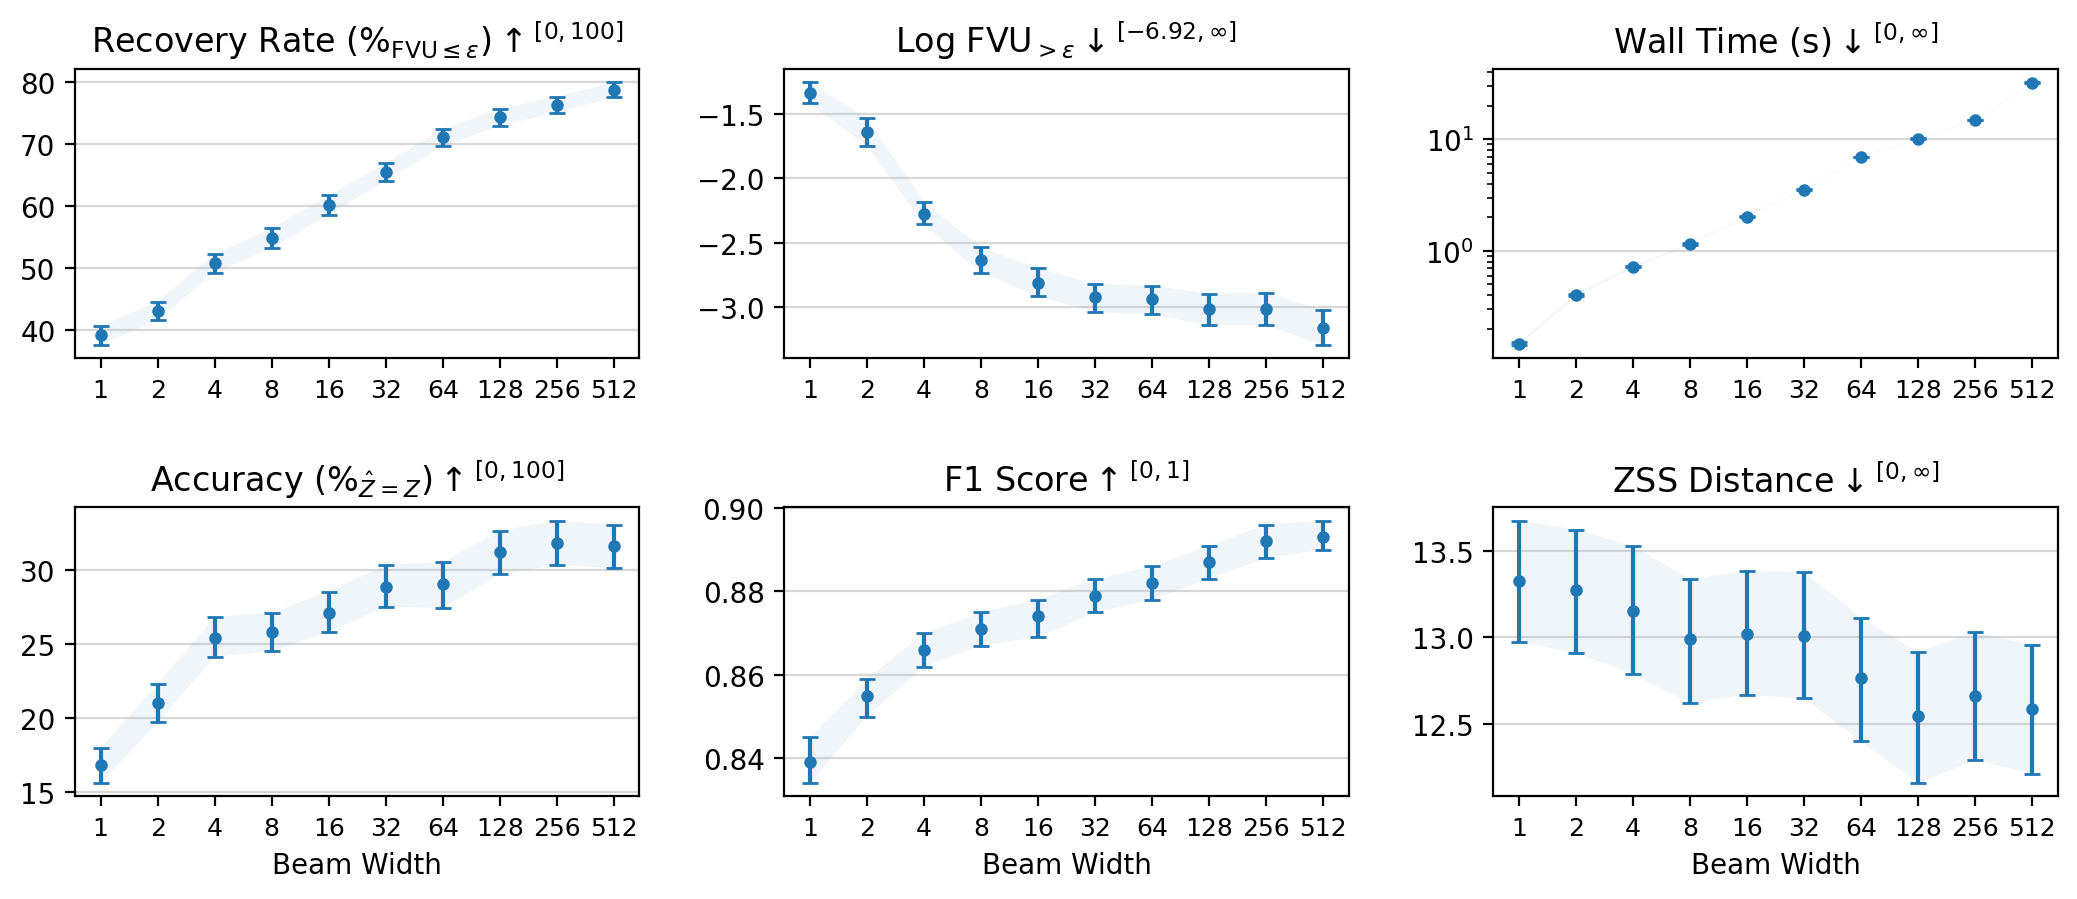

In [ ]:
show_metric_list = ['FVU-eps_accuracy', 'log_fvu_not_epsilon', 'wall_time', 'accuracy_best_beam', 'f1_score_best_beam', 'tree_edit_distance_best_beam']
objective_list = ['max', 'min', 'min', 'max', 'max', 'min']
y_label_list = ['Recovery Rate ($\%_{\\text{FVU} \leq \\epsilon}$)', 'Log FVU$_{>\\epsilon}$', 'Wall Time (s)', 'Accuracy ($\%_{\hat{Z} = Z}$)', 'F1 Score', 'ZSS Distance']
bounds_list = [(0, 100), (np.log10(np.finfo(np.float32).eps).round(2), None), (0, None), (0, 100), (0, 1), (0, None)]
sub_metric_list = ['mean', 'mean', 'mean', 'mean', 'mean', 'mean']
factor_list = [100, 1, 1, 100, 1, 1]
yscale_list = ['linear', 'linear', 'log', 'linear', 'linear', 'linear']
# ylim_list = [(0, 100), (np.log10(np.finfo(np.float32).eps), None), (0, None), (0, 1), (0, None)]
ylim_list = [None] * len(show_metric_list)

x = [configs[model]['beam_width'] for model in MODELS]

COLS = min(3, len(show_metric_list))
ROWS = np.ceil(len(show_metric_list) / COLS).astype(int)

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 3.5, ROWS * 2.3), dpi=200)

for i, (show_metric, sub_metric, ax, y_label, factor, ylim, objective, bounds, yscale) in enumerate(
    zip(show_metric_list, sub_metric_list, axes.flatten(), y_label_list, factor_list, ylim_list, objective_list, bounds_list, yscale_list)):
    y = total_summary_tables[sub_metric]['median'].T.loc[show_metric] * factor
    y_lower = total_summary_tables[sub_metric]['lower'].T.loc[show_metric] * factor
    y_upper = total_summary_tables[sub_metric]['upper'].T.loc[show_metric] * factor

    ax.errorbar(x, y, yerr=[y - y_lower, y_upper - y], fmt='.', markersize=7, capsize=3)
    sorted_indices = np.argsort(x)
    ax.fill_between(np.array(x)[sorted_indices], np.array(y_lower)[sorted_indices], np.array(y_upper)[sorted_indices], alpha=0.07)
    ax.set_xscale('log', base=2)
    arrow = ('$\\uparrow' if objective == 'max' else '$\\downarrow') + '^{[' + str(bounds[0]) + ', ' + (str(bounds[1]) if bounds[1] is not None else '\\infty') + ']}$'
    ax.set_title(y_label + f'{arrow}')
    ax.set_xticks(x)
    ax.set_xticklabels(x, fontsize=9)

    if i // COLS == ROWS - 1:
        ax.set_xlabel('Beam Width')
    # ax.set_xlabel('Beam Width')
    ax.grid(alpha=0.5, axis='y')

    ax.set_yscale(yscale)

    ax.set_ylim(ylim)

for ax in axes.flatten()[len(show_metric_list):]:
    ax.axis('off')

fig.tight_layout(w_pad=2, h_pad=2)

plt.savefig(get_path('results', 'analysis_beams', create=True, filename='analysis_beams_errorbars.svg'))

In [ ]:
sub_metrics = ['mean', 'median', '2.5p', '97.5p']
sub_metrics_functions = [naninfmean, np.nanmedian, partial(np.nanpercentile, q=2.5), partial(np.nanpercentile, q=97.5)]

total_summary_lengths = {length: {model: {column: {k: (np.nan, ) * 3 for k in sub_metrics} for column in compare_columns} for model in array_dfs.keys()} for length in range(32)}
aggregate_sets = ['feynman', 'soose_nc', 'nguyen', 'pool_15']
metrics = None

N_BOOTSTRAPS = 100

for model, model_dfs in array_dfs.items():
    if len(model_dfs) == 0:
        continue
    aggregated_data_lengths = {length: pd.concat([df[df['length_target'] == length] for test_set, df in model_dfs.items() if test_set in aggregate_sets]) for length in range(32)}

    for length in tqdm(range(32)):
        for column in compare_columns:
            if column in aggregated_data_lengths[length].columns:
                data = aggregated_data_lengths[length][column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
                total_summary_lengths[length][model][column] = {m: bootstrapped_metric_ci(data, f, n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}

    if metrics is None:
        metrics = total_summary_lengths[length][model][column].keys()

  0%|          | 0/32 [00:00<?, ?it/s]/tmp/ipykernel_700/3880369273.py:2: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.array(x)[np.isfinite(x)])
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1649: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  9%|▉         | 3/32 [00:00<00:04,  6.28it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
 62%|██████▎   | 20/32 [00:06<00:03,  3.17it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4623: RuntimeWarning: invalid value encountered 

In [ ]:
total_summary_tables_length = {
    length: {
        metric: {
            percentile:
                pd.DataFrame({
                model: {
                    column: total_summary_lengths[length][model][column][metric][k]
                    for column in compare_columns}
                    for model in total_summary.keys()}).T.round(3)
                    for k, percentile in enumerate(['median', 'lower', 'upper'])}
                    for metric in metrics}
                    for length in range(32)}

In [ ]:
from matplotlib.colors import LogNorm

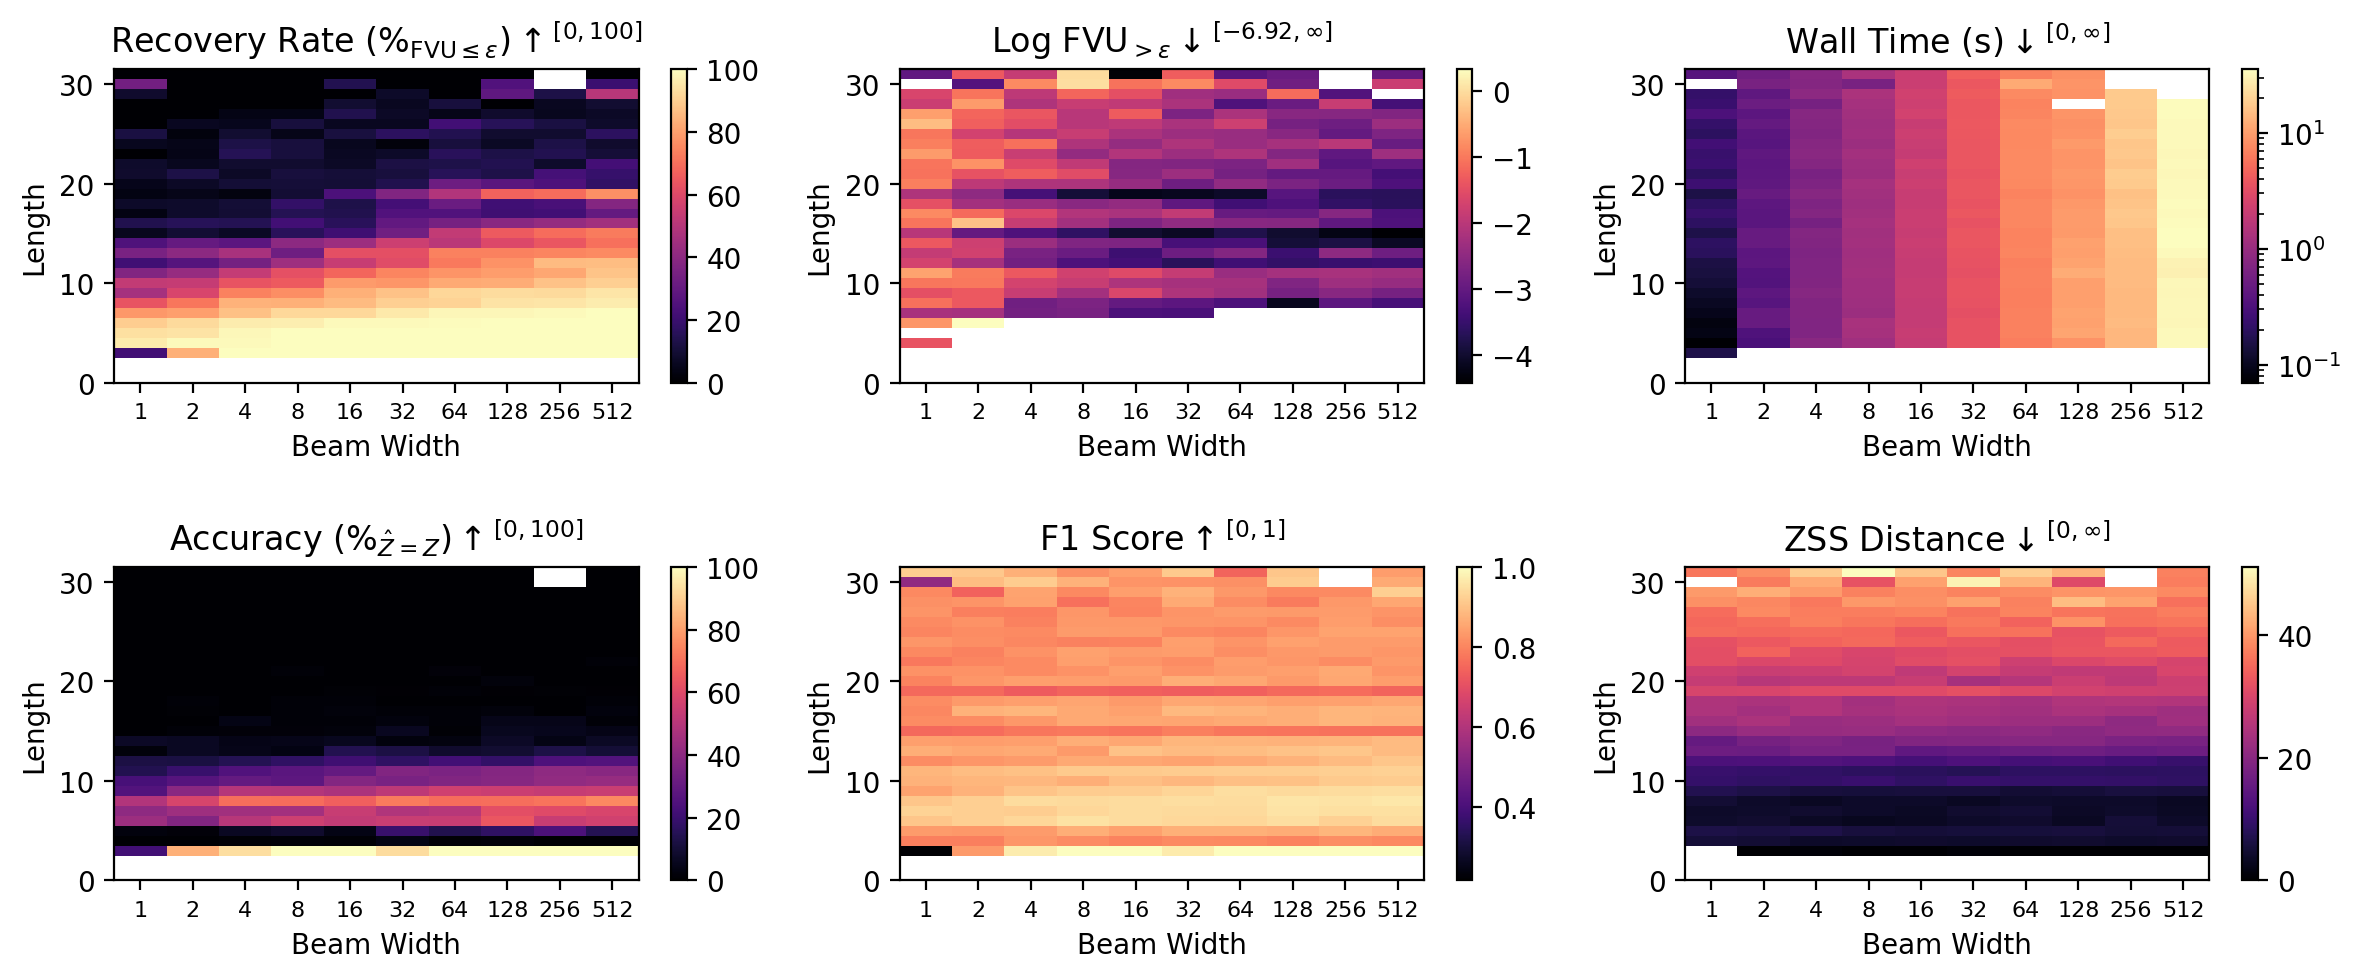

In [ ]:
show_metric_list = ['FVU-eps_accuracy', 'log_fvu_not_epsilon', 'wall_time', 'accuracy_best_beam', 'f1_score_best_beam', 'tree_edit_distance_best_beam']
objective_list = ['max', 'min', 'min', 'max', 'max', 'min']
y_label_list = ['Recovery Rate ($\%_{\\text{FVU} \leq \\epsilon}$)', 'Log FVU$_{>\\epsilon}$', 'Wall Time (s)', 'Accuracy ($\%_{\hat{Z} = Z}$)', 'F1 Score', 'ZSS Distance']
bounds_list = [(0, 100), (np.log10(np.finfo(np.float32).eps).round(2), None), (0, None), (0, 100), (0, 1), (0, None)]
sub_metric_list = ['mean', 'mean', 'mean', 'mean', 'mean', 'mean']
factor_list = [100, 1, 1, 100, 1, 1]
log_norm_list = [False, False, True, False, False, False]
ylim_list = [(0, 31.5)] * len(show_metric_list)

x = np.array([configs[model]['beam_width'] for model in MODELS])
sorted_indices = np.argsort(x)

COLS = min(3, len(show_metric_list))
ROWS = np.ceil(len(show_metric_list) / COLS).astype(int)

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 4, ROWS * 2.5), dpi=200)

for i, (show_metric, sub_metric, ax, y_label, factor, ylim, log_norm, bounds, objective) in enumerate(
    zip(show_metric_list, sub_metric_list, axes.flatten(), y_label_list, factor_list, ylim_list, log_norm_list, bounds_list, objective_list)):
    y = np.array([s[sub_metric]['median'].T.loc[show_metric] for s in total_summary_tables_length.values()]) * factor

    mesh = np.meshgrid(np.log2(x[sorted_indices]), np.arange(32))
    colormesh = ax.pcolormesh(mesh[0], mesh[1], y[:, sorted_indices], shading='auto', cmap='magma', norm=LogNorm() if log_norm else None, linewidth=0, rasterized=True)
    # colormesh.set_edgecolor('face')


    ax.set_xticks(np.log2(x))
    ax.set_xticklabels(x, fontsize=8)

    ax.set_ylabel('Length')
    ax.set_xlabel('Beam Width')
    arrow = ('$\\uparrow' if objective == 'max' else '$\\downarrow') + '^{[' + str(bounds[0]) + ', ' + (str(bounds[1]) if bounds[1] is not None else '\\infty') + ']}$'
    ax.set_title(y_label + f'{arrow}')
    
    # Add a little colorbar to each plot
    cb = plt.colorbar(colormesh, ax=ax)

    ax.set_ylim(ylim)

# hist_x = np.arange(32)
# hist_y = [len(aggregated_data_lengths[length]) for length in range(32)]

# hist_plot_x = np.empty(2 * len(hist_x))
# hist_plot_x[0::2] = hist_x - 0.5
# hist_plot_x[1::2] = hist_x + 0.5
# hist_plot_y = np.empty(2 * len(hist_y))
# hist_plot_y[0::2] = hist_y
# hist_plot_y[1::2] = hist_y

# axes.flatten()[-1].fill_betweenx(hist_plot_x, hist_plot_y, color='k', alpha=0.2)
# axes.flatten()[-1].set_xlim(0, None)
# axes.flatten()[-1].set_xlabel('Number of Test Equations')
# axes.flatten()[-1].set_ylabel('Length')
# axes.flatten()[-1].grid(alpha=0.5)
# axes.flatten()[-1].set_ylim(0, 32)
# axes.flatten()[-1].set_title('Aggregated Test Set Distribution')

# Add a phantom colorbar
# cb = plt.colorbar(colormesh, ax=axes.flatten()[-1])
# Hide the colorbar
# cb.ax.set_visible(False)

fig.tight_layout(w_pad=1, h_pad=2)

plt.savefig(get_path('results', 'analysis_beams', create=True, filename='analysis_beams_length_heatmap.svg'))